# CS 109B/Data Science: Final Project - Milestone 3
**Harvard University**<br>
**Spring 2017**<br>
**Date: ** April 19, 2017 

In [1]:
%matplotlib inline
import os
import sys
import nltk
import json
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import random
import time
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from collections import Counter
from unidecode import unidecode
from nltk.corpus import stopwords
from collections import OrderedDict
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold as sk_kfold
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import GridSearchCV

plt.style.use('ggplot')

# SVM Models

#### Clean and explore the data

In [2]:
# Load data
with open('themoviedb-sample-4-17-2017.json') as json_data:
    d = json.load(json_data)
data = pd.DataFrame(d)

# Sample size and data visualization
print(data.shape)
data.head()

(9549, 32)


,adult,backdrop_path,belongs_to_collection,budget,cast,cast_count,crew,crew_count,genre,genre_ids,...,revenue,reviews,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,None,None,0,[],0,"[{u'name': u'Bobby Sheehan', u'department': u'...",2,Documentary,[99],...,0,[],93.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,,Bought,False,0.0,0
1,False,None,None,0,[],0,"[{u'name': u'Nancy Donnelly', u'department': u...",2,Documentary,[99],...,0,[],60.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,,Egypt Underworld,False,3.8,2
2,False,/jWgtb7CRy3jWoXiz0IK352MG8b5.jpg,None,0,"[{u'name': u'Zhang Jin', u'character': u'Chau ...",8,"[{u'name': u'Douglas Kung Cheung-Tak', u'depar...",1,Action,[28],...,0,[],1.0,"[{u'name': u'广州话 / 廣州話', u'iso_639_1': u'cn'},...",Released,,Chinese Heroes,False,0.0,0
3,False,None,None,0,"[{u'name': u'Erika Eleniak', u'character': u'J...",5,"[{u'name': u'Brian Katkin', u'department': u'D...",2,Action,"[28, 18, 53]",...,0,[],92.0,"[{u'name': u'English', u'iso_639_1': u'en'}]",Released,he quake of the century... get ready to rumble...,Shakedown,False,3.0,2
4,False,None,None,0,"[{u'name': u'Erika Eleniak', u'character': u'J...",5,"[{u'name': u'Brian Katkin', u'department': u'D...",2,Drama,"[28, 18, 53]",...,0,[],92.0,"[{u'name': u'English', u'iso_639_1': u'en'}]",Released,he quake of the century... get ready to rumble...,Shakedown,False,3.0,2


#### Define Y variable

In [3]:
# Frequency of genre in the sample
genre_frequency = data['genre'].value_counts()/len(data)
genre_frequency = pd.DataFrame(genre_frequency)
genre_frequency.rename(columns={'genre': 'prop'}, inplace=True)
genre_frequency

,prop
Drama,0.184941
Comedy,0.127867
Documentary,0.099173
Thriller,0.090585
Action,0.071107
Horror,0.067861
Romance,0.054456
Crime,0.039376
Science Fiction,0.036548
Family,0.036025


### Models 1 and 2.  Unweighted and weighted SVM using only *overview* and *reviews* as features

#### Define X: Converting overview and reviews to word-frequency vectors

In [4]:
# Keeping only genres, overviews, and reviews to make a fair comparison with the Naive Bayes model
raw = data[['genre', 'reviews', 'overview', 'id']].copy()
print(raw.shape)
raw.head()


(9549, 4)


,genre,reviews,overview,id
0,Documentary,[],Modern industrialization is no longer about st...,328380
1,Documentary,[],The documentary is an analysis of the fascinat...,112052
2,Action,[],A good-natured kung fu kid gets caught up in c...,201706
3,Action,[],In Los Angeles a deadly plague called the 'Pan...,61803
4,Drama,[],In Los Angeles a deadly plague called the 'Pan...,61803


In [5]:
df = raw[['reviews', 'overview', 'genre', 'id']]
df.rename(columns={'overview': 'movie_overview'}, inplace=True)

stops = set(nltk.corpus.stopwords.words('english'))
all_words_ever = []

def add_cols_for_all_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if len(word) > 2 and unidecode(word.lower()) not in stops]
        all_words_ever.extend(words)
    return row

def parse_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if word.lower() in top_words]
        for word in words:
            row[unidecode(word)] += 1        
    return row

In [6]:
df['review_text'] = df.apply(lambda row: [x['content'] for x in row['reviews']], axis = 1)
df.head()

,reviews,movie_overview,genre,id,review_text
0,[],Modern industrialization is no longer about st...,Documentary,328380,[]
1,[],The documentary is an analysis of the fascinat...,Documentary,112052,[]
2,[],A good-natured kung fu kid gets caught up in c...,Action,201706,[]
3,[],In Los Angeles a deadly plague called the 'Pan...,Action,61803,[]
4,[],In Los Angeles a deadly plague called the 'Pan...,Drama,61803,[]


In [7]:
df = df.apply(lambda x: add_cols_for_all_words(x), axis = 1)
len(all_words_ever), len(set(all_words_ever))

(292576, 25820)

In [8]:
# Use the optimal word_count
best_word_count = 400
top_words = [word[0] for word in Counter(all_words_ever).most_common(best_word_count)]
len(top_words)

400

In [9]:
for word in top_words:
    df[unidecode(word)] = 0

df = df.apply(lambda x: parse_words(x), axis = 1)
    
print(df.shape)
df.head()

(9549, 405)


,reviews,movie_overview,genre,id,review_text,one,life,new,world,film,...,features,officer,california,alive,english,second,accident,track,professor,right
0,[],Modern industrialization is no longer about st...,Documentary,328380,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[],The documentary is an analysis of the fascinat...,Documentary,112052,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[],A good-natured kung fu kid gets caught up in c...,Action,201706,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[],In Los Angeles a deadly plague called the 'Pan...,Action,61803,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[],In Los Angeles a deadly plague called the 'Pan...,Drama,61803,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Define train and test sets

In [10]:
# Define Y and X matrixes
X = df[df.columns[-best_word_count:]]
y = df['genre']
y = y.apply(lambda x: str(x))
X.shape, y.shape

((9549, 400), (9549,))

In [11]:
# Train/test split
n_samples = len(X)
train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

x_train = X[train_indices]
y_train = y[train_indices]

x_test = X[~train_indices]
y_test = y[~train_indices]


#### Function to optimize parameter C on Unweighted SVM

In [32]:
#--------  optimum_cvc
# Function to optimize parameter C on Unweighted SVM
# Input: 
#      x_train (array of train predictors)
#      y_train (array of train responses) 
#      n_folds (float; number of folds for cross validation)    
#      seed (float; fix the random the random state)
#      weight (string; type of weight)
# Output:
#      best_c (optimal value of C)
#      best_k (optimal kernel)
#      results_df (DataFrame for scores, std_scores, per model)   

def optimum_cvc(x_train, y_train, n_folds, seed, weight):
    n_folds = n_folds
    seed = seed
    kfold = sk_kfold(len(y_train), n_folds, random_state=seed)
    scores = list()
    scores_std = list()
    C = list()
    gamma = list()
    
    # To keep track of the best model
    best_score = 0
    for c in np.logspace(1, 2, 3):
        for g in np.logspace(-4, 1, 3):
            model = SVC(C=c, gamma=g, class_weight = weight)
            model.fit(x_train, y_train)
            i_scores = cross_val_score(model, x_train, y_train, cv=kfold, n_jobs=1)
            scores.append(np.mean(i_scores))
            scores_std.append(np.std(i_scores))
            C.append(c)
            gamma.append(g)
            
            # Update our record of the best parameters see so far
            if np.mean(i_scores) > best_score:
                best_score = np.mean(i_scores)
                best_C = c
                best_gamma = g
    
    # Scores, scores std, for different combinations of C and gamma              
    scores, scores_std = np.array(scores), np.array(scores_std)
    C = np.array(C)
    gamma = np.array(gamma)
    
    # Results
    results = np.column_stack([scores, C, gamma])
    results_df = pd.DataFrame(results, columns = ['scores', 'C', 'gamma'])
    
    return best_C, best_gamma, results_df


#### Tune Parameters Unweighted SVM model

In [17]:
# Define parameters
n_folds = 5
seed = 42

# Unweighted SVM 
# Standarize data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sd = scaler.transform(x_train)   

start = time.time()
best_c, best_g, results_df = optimum_cvc(x_train_sd, y_train, n_folds, seed, None)
end = time.time()

time_elapsed = end - start

print 'Best C - Unweighted: ' + str(best_c)
print 'Best gamma - Unweighted: ' + str(best_g)
print 'Tuning, Time elapsed - Unweighted SVM:', time_elapsed, "sec"

Best C - Unweighted: 10.0
Best gamma - Unweighted: 0.0001
Tuning, Time elapsed - Unweighted SVM: 2673.13145494 sec


#### Tune Parameters Weighted SVM model

In [31]:
# Weighted SVM 
start = time.time()
best_c_w, best_g_w, results_df_w = optimum_cvc(x_train_sd, y_train, n_folds, seed, 'balanced')
end = time.time()

time_elapsed = end - start

print 'Best C- Weighted: ' + str(best_c_w)
print 'Best gamma - Weighted: ' + str(best_g_w)
print 'Tuning, Time elapsed - Weighted SVM:', time_elapsed, "sec"

Best C- Weighted: 10.0
Best gamma - Weighted: 0.0001
Tuning, Time elapsed - Weighted SVM: 2754.5096612 sec


#### Accuracy Unweighted SVM

* Overall accuracy

In [18]:
##  Unweighted model: Predict on test sample

# Fit model in train sample based on optimal parameters 
start = time.time()
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sd = scaler.transform(x_train)   
model = SVC(C=best_c, gamma = best_g, class_weight = None)
model.fit(x_train_sd, y_train)
end = time.time()

time_elapsed = end - start
print "Time elapsed - Unweighted SVM:", time_elapsed, "sec"

# Standarize test sample
x_test_sd = scaler.transform(x_test)   

# Prediction on test sample
y_pred = model.predict(x_test_sd)

# Overall accuracy
score = round(model.score(x_test_sd, y_test), 4)
print '\n' '# Test accuracy:', score

Time elapsed - Unweighted SVM: 47.8535420895 sec

# Test accuracy: 0.2351


* Accuracy rate per genre

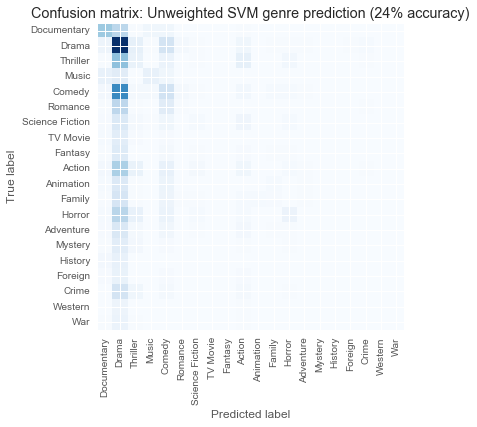

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

# Visual inspection of confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(y_test.nunique())
plt.xticks(tick_marks, y_test.unique(), rotation=90)
plt.yticks(tick_marks, y_test.unique())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: Unweighted SVM genre prediction ({:.0f}% accuracy)'.format(score*100))
plt.show()

#### Accuracy Weighted SVM

* Overall accuracy

In [33]:
##  Weighted model: Predict on test sample

# Fit model in train sample based on optimal parameters 
start = time.time()
model = SVC(C=best_c_w, gamma = best_g_w, class_weight = 'balanced')
model.fit(x_train_sd, y_train)
end = time.time()

time_elapsed_w = end - start
print "Time elapsed - Weighted SVM:", time_elapsed_w, "sec"

# Prediction on test sample
y_pred_w = model.predict(x_test_sd)

# Overall accuracy
score = round(model.score(x_test_sd, y_test), 4)
print '\n' '# Test accuracy:', score

Time elapsed - Weighted SVM: 63.4150528908 sec

# Test accuracy: 0.1695


* Accuracy per genre

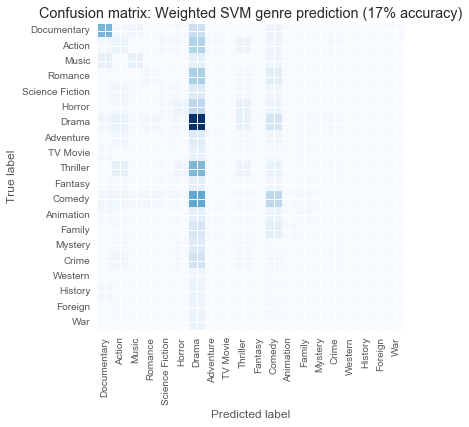

In [34]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

# Visual inspection of confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(y_test.nunique())
plt.xticks(tick_marks, y_test.unique(), rotation=90)
plt.yticks(tick_marks, y_test.unique())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: Weighted SVM genre prediction ({:.0f}% accuracy)'.format(score*100))
plt.show()

### Models 3 and 4.  Unweighted and weighted SVM using all features

#### Define X: Adding more features to our baseline models

* Director and main cast

In [37]:
# Unique identifier
len(data["id"].unique())

# Empty data frame to store results
results = pd.DataFrame({"id": data["id"]})
results["director"] = "MISS"
results["cast1"] = "MISS"
results["cast2"] = "MISS"
results["cast3"] = "MISS"

# Looping to get names
for i in data.index:
    crew = pd.DataFrame(data.ix[i, "crew"])
    if crew.shape[0] >= 1:
        try:
            results.ix[i, "director"] = crew.ix[crew["job"] == "Director", "name"].iloc[0]
            # need to correct for multiple producers
        except:
            pass;
    cast = pd.DataFrame(data.ix[i, "cast"])
    if cast.shape[0] >= 1:
        try:
            results.ix[i, "cast1"] = cast.ix[cast["order"] == 1, "name"].iloc[0]
            results.ix[i, "cast2"] = cast.ix[cast["order"] == 2, "name"].iloc[0]
            results.ix[i, "cast3"] = cast.ix[cast["order"] == 3, "name"].iloc[0]
        except:
            pass;

        
# Getting to the movie level
cast_dir = results
cast_dir.head()

,id,director,cast1,cast2,cast3
0,328380,Bobby Sheehan,MISS,MISS,MISS
1,112052,Nancy Donnelly,MISS,MISS,MISS
2,201706,Douglas Kung Cheung-Tak,Chin Ka-Lok,Leila Tong,Lee San-San
3,61803,Brian Katkin,Ron Perlman,Fred Dryer,Wolf Larson
4,61803,Brian Katkin,Ron Perlman,Fred Dryer,Wolf Larson


* Additional variables

In [38]:
# Additional movie features
features = ['adult', 'budget','cast_count','id','popularity','release_date','revenue', 'runtime', 
                'status', 'vote_average', 'vote_count']
add_features = data[features]
add_features.head()

,adult,budget,cast_count,id,popularity,release_date,revenue,runtime,status,vote_average,vote_count
0,False,0,0,328380,0.010669,2015-01-02,0,93.0,Released,0.0,0
1,False,0,0,112052,0.000782,2009-09-20,0,60.0,Released,3.8,2
2,False,0,8,201706,0.002123,2001-07-12,0,1.0,Released,0.0,0
3,False,0,5,61803,0.097457,2002-12-24,0,92.0,Released,3.0,2
4,False,0,5,61803,0.097457,2002-12-24,0,92.0,Released,3.0,2


In [39]:
# Description of features by percentage of missing values and variable type 
missing = ((add_features.isnull().sum()/len(add_features))*100).astype(float)
types = add_features.dtypes

data_description = pd.DataFrame(np.column_stack([missing, types]), \
                            index = add_features.columns, columns = ['% Missing', 'Type'])
print "## Data Description ##"
data_description

## Data Description ##


,% Missing,Type
adult,0,bool
budget,0,int64
cast_count,0,int64
id,0,int64
popularity,0,float64
release_date,0,object
revenue,0,int64
runtime,0.659755,float64
status,0,object
vote_average,0,float64


Impute missing values

In [40]:
# Impute variables using median imputation:
imp = preprocessing.Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(add_features['runtime'].reshape(-1,1))
data_imp = pd.DataFrame(imp.transform(add_features['runtime'].reshape(-1,1)), columns = [imp])
add_features.loc[:, 'runtime'] = data_imp.values
add_features.head()

,adult,budget,cast_count,id,popularity,release_date,revenue,runtime,status,vote_average,vote_count
0,False,0,0,328380,0.010669,2015-01-02,0,93.0,Released,0.0,0
1,False,0,0,112052,0.000782,2009-09-20,0,60.0,Released,3.8,2
2,False,0,8,201706,0.002123,2001-07-12,0,1.0,Released,0.0,0
3,False,0,5,61803,0.097457,2002-12-24,0,92.0,Released,3.0,2
4,False,0,5,61803,0.097457,2002-12-24,0,92.0,Released,3.0,2


Consolidate X 

In [41]:
# Redifine X
names = list(X.columns.values) + list(add_features.columns.values) + list(cast_dir.columns.values)
X_all = pd.DataFrame(np.column_stack([X, add_features, cast_dir]), columns = names)
X_all.head()

,one,life,new,world,film,young,two,man,story,love,...,revenue,runtime,status,vote_average,vote_count,id,director,cast1,cast2,cast3
0,0,0,0,0,0,0,0,0,0,0,...,0,93,Released,0,0,328380,Bobby Sheehan,MISS,MISS,MISS
1,0,0,0,0,0,0,0,0,0,0,...,0,60,Released,3.8,2,112052,Nancy Donnelly,MISS,MISS,MISS
2,0,0,0,0,0,0,0,0,0,0,...,0,1,Released,0,0,201706,Douglas Kung Cheung-Tak,Chin Ka-Lok,Leila Tong,Lee San-San
3,0,0,0,0,0,0,0,0,0,0,...,0,92,Released,3,2,61803,Brian Katkin,Ron Perlman,Fred Dryer,Wolf Larson
4,0,0,0,0,0,0,0,0,0,0,...,0,92,Released,3,2,61803,Brian Katkin,Ron Perlman,Fred Dryer,Wolf Larson


In [42]:
# Encode categorical variables 
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Categorical columns for use in one-hot encoder
categorical = (X_all.dtypes.values != np.dtype('float64'))

# Encode all labels
X_all_enc = X_all.apply(encode_categorical)
X_all_enc.head()

,one,life,new,world,film,young,two,man,story,love,...,revenue,runtime,status,vote_average,vote_count,id,director,cast1,cast2,cast3
0,0,0,0,0,0,0,0,0,0,0,...,0,93,5,0,0,4062,388,2254,2200,2090
1,0,0,0,0,0,0,0,0,0,0,...,0,60,5,27,2,2375,2638,2254,2200,2090
2,0,0,0,0,0,0,0,0,0,0,...,0,1,5,0,0,2924,1014,628,2081,1983
3,0,0,0,0,0,0,0,0,0,0,...,0,92,5,19,2,1662,447,3071,1161,3359
4,0,0,0,0,0,0,0,0,0,0,...,0,92,5,19,2,1662,447,3071,1161,3359


In [43]:
# Train/test split
n_samples = len(X_all_enc)
train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

x_train = X_all_enc[train_indices]
y_train = y[train_indices]

x_test = X_all_enc[~train_indices]
y_test = y[~train_indices]

#### Tune Parameters Unweighted SVM model - all features

In [44]:
# Define parameters
n_folds = 5
seed = 42

# Unweighted SVM 
# Standarize data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sd = scaler.transform(x_train)   

start = time.time()
best_c, best_g, results_df = optimum_cvc(x_train_sd, y_train, n_folds, seed, None)
end = time.time()

time_elapsed = end - start

print 'Best C - Unweighted: ' + str(best_c)
print 'Best gamma - Unweighted: ' + str(best_g)
print 'Tuning, Time elapsed - Unweighted SVM - all features:', time_elapsed, "sec"

Best C - Unweighted: 31.6227766017
Best gamma - Unweighted: 0.0001
Tuning, Time elapsed - Unweighted SVM - all features: 2815.78565407 sec


#### Tune Parameters weighted SVM model - all features

In [48]:
# Weighted SVM 
start = time.time()
best_c_w, best_g_w, results_df_w = optimum_cvc(x_train_sd, y_train, n_folds, seed, 'balanced')
end = time.time()

time_elapsed = end - start

print 'Best C- Weilghted: ' + str(best_c_w)
print 'Best gamma - Weighted: ' + str(best_g_w)
print 'Tuning, Time elapsed - Weighted SVM - all features:', time_elapsed, "sec"

Best C- Weighted: 10.0
Best gamma - Weighted: 0.0001
Tuning, Time elapsed - Weighted SVM - all features: 2607.83162379 sec


#### Accuracy unweighted SVM

* Overall accuracy

In [53]:
##  Unweighted model: Predict on test sample

# Fit model in train sample based on optimal parameters 
start = time.time()
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_sd = scaler.transform(x_train)   
model = SVC(C=best_c, gamma = best_g, class_weight = None)
model.fit(x_train_sd, y_train)
end = time.time()

time_elapsed = end - start
print "Time elapsed - Unweighted SVM:", time_elapsed, "sec"

# Standarize test sample
x_test_sd = scaler.transform(x_test)   

# Prediction on test sample
y_pred = model.predict(x_test_sd)

# Overall accuracy
score = round(model.score(x_test_sd, y_test), 4)
print '\n' '# Test accuracy:', score

Time elapsed - Unweighted SVM: 37.6214249134 sec

# Test accuracy: 0.2519


* Accuracy per genre

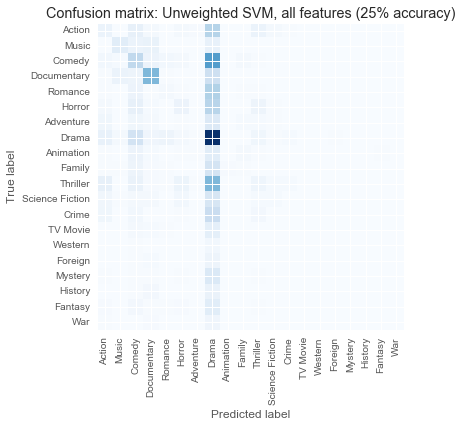

In [56]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

# Visual inspection of confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(y_test.nunique())
plt.xticks(tick_marks, y_test.unique(), rotation=90)
plt.yticks(tick_marks, y_test.unique())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: Unweighted SVM, all features ({:.0f}% accuracy)'.format(score*100))
plt.show()

#### Accuracy weighted SVM

* Overall accuracy

In [57]:
##  Weighted model: Predict on test sample

# Fit model in train sample based on optimal parameters 
start = time.time()
model = SVC(C=best_c_w, gamma = best_g_w, class_weight = 'balanced')
model.fit(x_train_sd, y_train)
end = time.time()

time_elapsed_w = end - start
print "Time elapsed - Weighted SVM:", time_elapsed_w, "sec"

# Prediction on test sample
y_pred_w = model.predict(x_test_sd)

# Overall accuracy
score = round(model.score(x_test_sd, y_test), 4)
print '\n' '# Test accuracy:', score

Time elapsed - Weighted SVM: 51.5446100235 sec

# Test accuracy: 0.1695


* Accuracy per genre

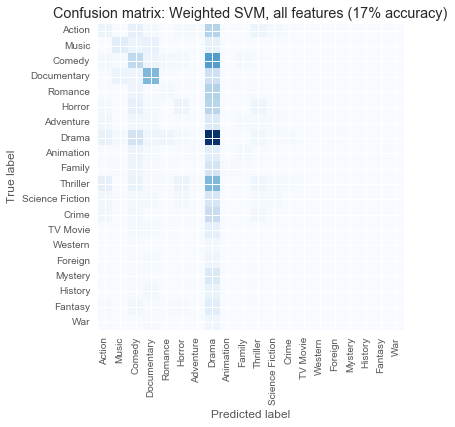

In [58]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

# Visual inspection of confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(y_test.nunique())
plt.xticks(tick_marks, y_test.unique(), rotation=90)
plt.yticks(tick_marks, y_test.unique())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: Weighted SVM, all features ({:.0f}% accuracy)'.format(score*100))
plt.show()

----